In [2]:
import pandas as pd

# Load the uploaded data
data_path = './data_in/total_df.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataframe and its summary
data_info = data.info()
data_head = data.head()
data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105086 entries, 0 to 105085
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Order_id                       105086 non-null  object 
 1   Order_item_id                  105086 non-null  int64  
 2   Product_id                     105086 non-null  object 
 3   Seller_id                      105086 non-null  object 
 4   Price                          105086 non-null  float64
 5   Freight_value                  105086 non-null  float64
 6   Customer_id                    105086 non-null  object 
 7   Order_status                   105086 non-null  object 
 8   Order_purchase_timestamp       105086 non-null  object 
 9   Order_delivered_carrier_date   105086 non-null  object 
 10  Order_delivered_customer_date  105086 non-null  object 
 11  Order_estimated_delivery_date  105086 non-null  object 
 12  Seller_zipcode_prefix         

C:\Users\SeonB2\AppData\Local\Temp\ipykernel_15652\612010575.py:5: DtypeWarning: Columns (16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


(None,
       Order_id  Order_item_id     Product_id    Seller_id  Price  \
 0  ORDER_75477              1  PRODUCT_23128  SELLER_0452   58.9   
 1  ORDER_63604              1  PRODUCT_24351  SELLER_0414  239.9   
 2  ORDER_05566              1  PRODUCT_20226  SELLER_1637  199.0   
 3  ORDER_04632              1  PRODUCT_07878  SELLER_1445  199.9   
 4  ORDER_61452              1  PRODUCT_03505  SELLER_0581   21.9   
 
    Freight_value     Customer_id Order_status Order_purchase_timestamp  \
 0          13.29  CUSTOMER_58023    delivered      2018-09-13 08:59:02   
 1          19.93  CUSTOMER_30341    delivered      2018-04-26 10:53:06   
 2          17.87  CUSTOMER_30949    delivered      2019-01-14 14:33:31   
 3          18.14  CUSTOMER_06713    delivered      2018-02-04 13:57:51   
 4          12.69  CUSTOMER_20396    delivered      2018-05-15 21:42:34   
 
   Order_delivered_carrier_date  ... Product_width_cm Revenue  \
 0          2018-09-19 18:34:16  ...             14.0    58.

In [3]:
# Check for missing values and data types for key columns
missing_values = data.isnull().sum()
data_types = data.dtypes

missing_values, data_types


(Order_id                         0
 Order_item_id                    0
 Product_id                       0
 Seller_id                        0
 Price                            0
 Freight_value                    0
 Customer_id                      0
 Order_status                     0
 Order_purchase_timestamp         0
 Order_delivered_carrier_date     0
 Order_delivered_customer_date    0
 Order_estimated_delivery_date    0
 Seller_zipcode_prefix            0
 Seller_city                      0
 Seller_state                     0
 Product_category_name            0
 Product_weight_g                 0
 Product_length_cm                0
 Product_height_cm                0
 Product_width_cm                 0
 Revenue                          0
 Payment_sequential               0
 Payment_type                     0
 Payment_installments             0
 Payment_value                    0
 Customer_unique_id               0
 Customer_zipcode_prefix          0
 Customer_city              

In [4]:
# Drop rows where review information is missing
data_cleaned = data.dropna(subset=['Review_score', 'Review_id', 'Review_creation_date', 'Review_answer_timestamp'])

# Convert product dimension and weight columns to numeric
dimension_cols = ['Product_weight_g', 'Product_length_cm', 'Product_height_cm', 'Product_width_cm']
data_cleaned[dimension_cols] = data_cleaned[dimension_cols].apply(pd.to_numeric, errors='coerce')

# Drop any rows that could not be converted (if any)
data_cleaned = data_cleaned.dropna(subset=dimension_cols)

# Convert dates from string to datetime
date_columns = ['Order_purchase_timestamp', 'Order_delivered_customer_date', 'Review_creation_date', 'Review_answer_timestamp']
for col in date_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col], errors='coerce')

# Calculate derived columns
# Delivery speed in days
data_cleaned['Delivery_speed_days'] = (data_cleaned['Order_delivered_customer_date'] - data_cleaned['Order_purchase_timestamp']).dt.days

# Review response time in days
data_cleaned['Review_response_time_days'] = (data_cleaned['Review_answer_timestamp'] - data_cleaned['Review_creation_date']).dt.days

# Display the new columns and any remaining missing values
derived_columns_info = data_cleaned[['Delivery_speed_days', 'Review_response_time_days']].describe()
missing_values_updated = data_cleaned.isnull().sum()
derived_columns_info, missing_values_updated


KeyError: ['Review_score', 'Review_id', 'Review_creation_date', 'Review_answer_timestamp']

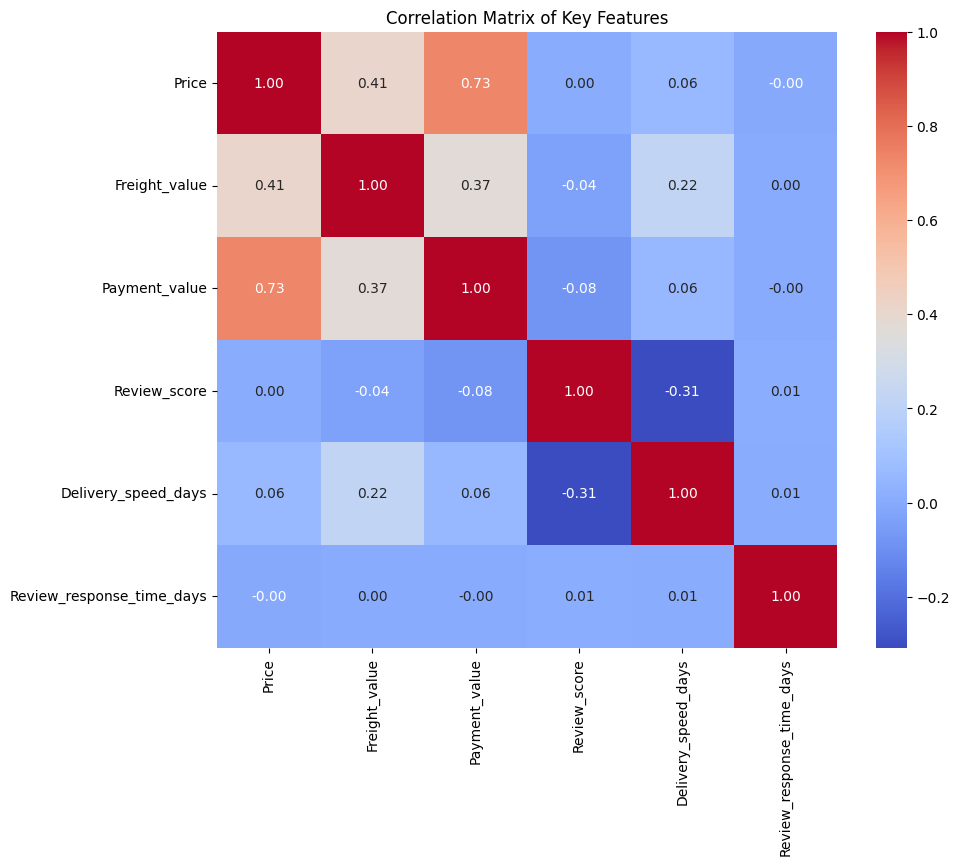

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select key features for correlation analysis
features = [
    'Price', 'Freight_value', 'Payment_value', 'Review_score',
    'Delivery_speed_days', 'Review_response_time_days'
]

# Calculate the correlation matrix
correlation_matrix = data_cleaned[features].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Key Features")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
X = data_cleaned[['Price', 'Payment_value', 'Review_score', 'Delivery_speed_days']]
y = data_cleaned['Revenue']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate the performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(4655.754707541056, 0.8873554697211545)

어떤 컬럼이 영향을 미친 건지 뜯어보기